In [1]:
%cd "~/Projects/Segmentation/TreeSeg"
import json
import math
import os
from pathlib import Path

import hashlib
import matplotlib.pyplot as plt
import networkx as nx
import nvdiffrast.torch as dr
import torch
from torch import Tensor, nn
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
import yaml
from rich.console import Console
from rich.tree import Tree
import torch_geometric as pyg

import tree_segmentation as ts
import tree_segmentation.extension as ext
from tree_segmentation.extension import ops_3d, Mesh, utils
from semantic_sam import SemanticSAM, semantic_sam_l
from tree_segmentation import Tree3Dv2, Tree3D, TreePredictor, TreeSegmentMetric, TreeData, MaskData
from tree_segmentation.util import show_masks, show_all_levels, get_hash_name
from evaluation.batch_eval_PartNet import get_mesh_and_gt_tree, get_images
import pycocotools.mask as mask_util

/home/wan/Projects/Segmentation/TreeSeg
Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


2023-08-02 12:30:31.006938: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-02 12:30:32.109393: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/wan/miniconda3/envs/wan/lib/python3.8/site-packages/cv2/../../lib64:/usr/local/cuda-11.7/lib64:/usr/local/cuda-11.7/lib64:/usr/local/cuda-11.7/lib64:/usr/local/cuda-11.7/lib64:/usr/local/cuda-11.7/lib64:
2023-08-02 12:30:32.109545: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so

In [2]:
print(torch.__version__)
%load_ext autoreload
%autoreload 2
%matplotlib inline
torch.set_grad_enabled(False)
console = Console()
device = torch.device("cuda")
# device = torch.device("cpu")
utils.set_printoptions(linewidth=120)

2.0.1+cu117


In [3]:
data_root = Path('/data5/SA-1B/')
data_part_1 = data_root.joinpath(f"{0:06d}")
images_paths = list(data_part_1.glob('*.jpg'))
print(f"There are {len(images_paths)} images")
print(len(list(data_part_1.glob('*.json'))))

There are 11186 images
11186


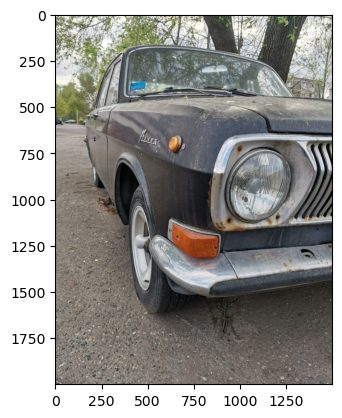

In [4]:
image = utils.load_image(images_paths[0])
plt.imshow(image)

In [5]:

masks = []
scores = []
with images_paths[0].with_suffix('.json').open('r') as f:
    data = json.load(f)
annotations = data['annotations']
for ann in annotations:
    scores.append(ann['predicted_iou'])
    masks.append(mask_util.decode(ann['segmentation']))
scores = np.stack(scores)
masks = np.stack(masks)
print(utils.show_shape(scores, masks))
tree2d = TreeData(MaskData(masks=torch.from_numpy( masks), iou_preds=torch.from_numpy(scores)))


numpy((56,), float64), numpy((56, 2000, 1500), uint8)


In [6]:
tree2d.update_tree()
tree2d.print_tree()

0: Tree Root
├── 56
│   ├── 2
│   ├── 3
│   ├── 8
│   ├── 10
│   ├── 11
│   ├── 12
│   ├── 15
│   ├── 18
│   ├── 24
│   ├── 27
│   ├── 28
│   ├── 29
│   ├── 33
│   ├── 35
│   ├── 42
│   └── 43
├── 53
├── 48
│   ├── 22
│   └── 25
├── 38
├── 37
├── 36
├── 30
│   ├── 55
│   ├── 54
│   │   ├── 49
│   │   ├── 51
│   │   │   └── 32
│   │   └── 52
│   ├── 50
│   ├── 45
│   │   ├── 47
│   │   └── 46
│   ├── 44
│   │   └── 23
│   ├── 41
│   ├── 40
│   │   └── 17
│   │       └── 20
│   ├── 39
│   ├── 34
│   ├── 31
│   │   ├── 21
│   │   └── 13
│   ├── 6
│   ├── 9
│   ├── 14
│   │   └── 1
│   ├── 16
│   └── 19
├── 26
├── 7
├── 5
└── 4

5

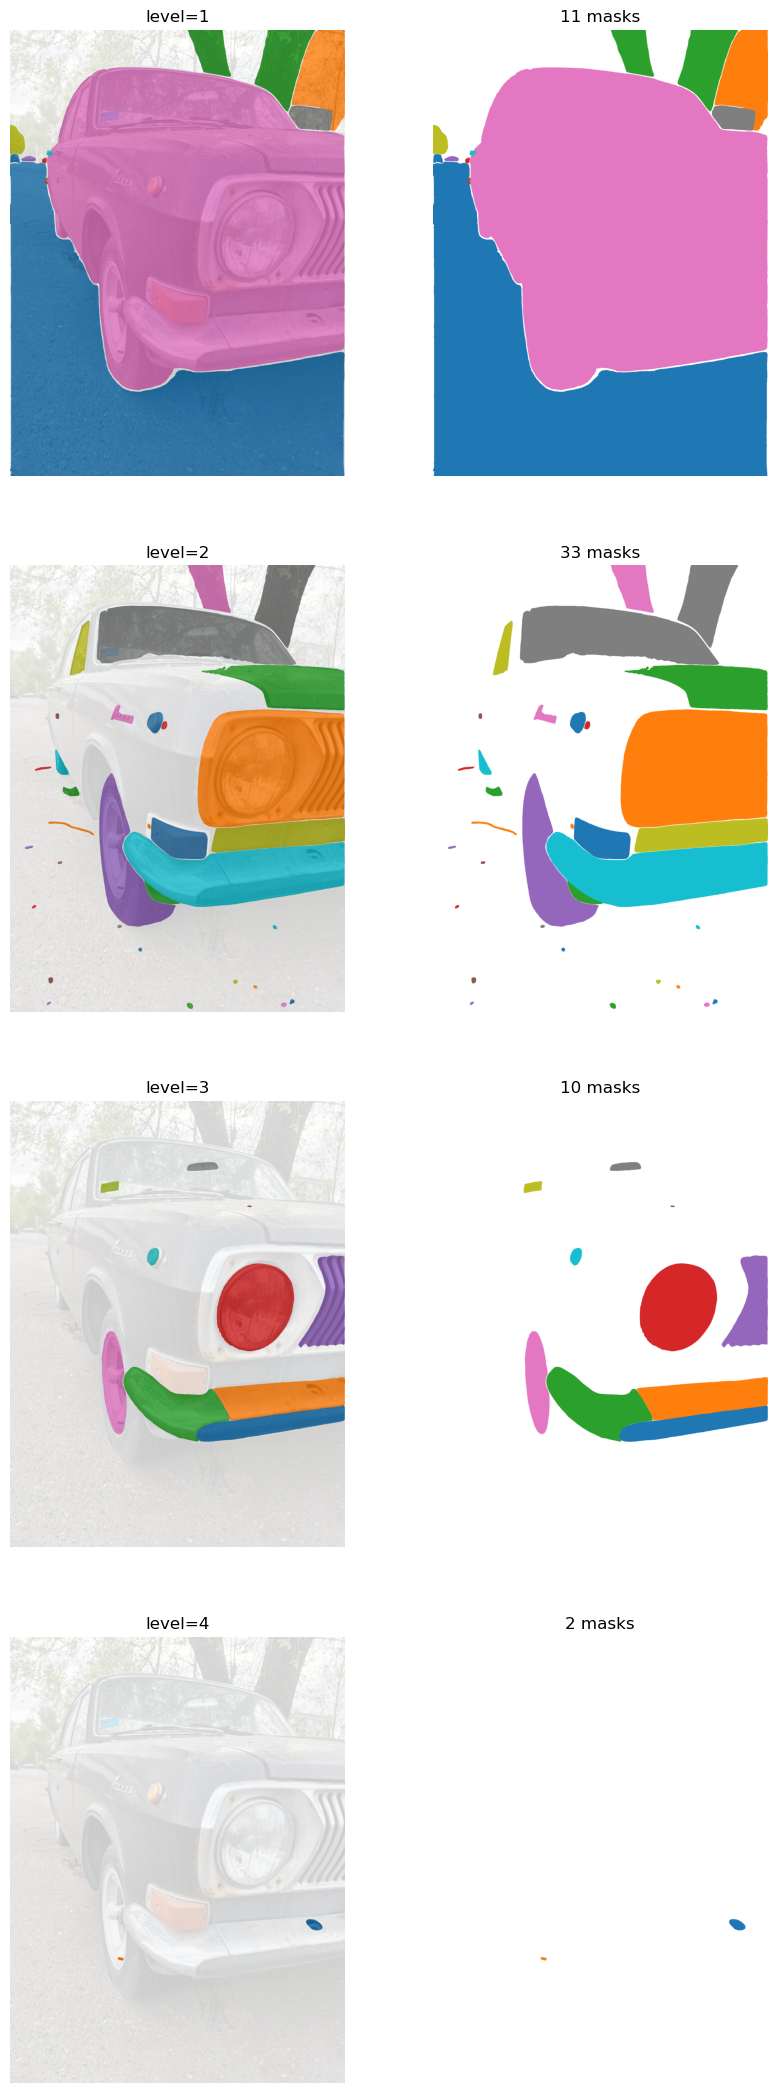

In [11]:
show_all_levels(image, tree2d, alpha=0.8)